In [1]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.6 MB/s eta 0:00:0000:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import tensorflow as tf

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from math import ceil

2024-11-21 21:05:45.263160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 21:05:45.263305: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 21:05:45.393107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Check GPU availability
if not tf.config.list_physical_devices('GPU'):
    print("GPU not available. Please check your TensorFlow installation and GPU setup.")
else:
    print("GPU is available and TensorFlow will use it.")

GPU is available and TensorFlow will use it.


In [4]:
# Create dataframe function
def create_df(path):
    dd = {"images": [], "labels": []}
    
    for i in os.listdir(path):
        img_dir = os.path.join(path, i)
        for j in os.listdir(img_dir):
            img = os.path.join(img_dir, j)
            dd["images"] += [img]
            dd["labels"] += [i]
            
    return pd.DataFrame(dd)

In [5]:
# Load dataframes
train_df = create_df("/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/train")
val_df = create_df("/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/valid")
test_df = create_df("/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/test")

In [6]:
# Data Augmentation
"""
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
"""


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
IMG_SIZE = 224
batch_size = 64

In [8]:
# Data Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='labels',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)  # Ensure the test generator does not shuffle the data

Found 896 validated image filenames belonging to 16 classes.
Found 128 validated image filenames belonging to 16 classes.
Found 256 validated image filenames belonging to 16 classes.


In [9]:
# Build VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [10]:
# Initialize LabelEncoder
le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])
val_df['labels'] = le.transform(val_df['labels'])
test_df['labels'] = le.transform(test_df['labels'])

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False
    
from tensorflow.keras.optimizers import RMSprop

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-6)

In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[checkpoint, early_stop, reduce_lr])

Epoch 1/200


I0000 00:00:1732223169.835306     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - ETA: 0s - loss: 2.5461 - accuracy: 0.2723
Epoch 1: val_loss improved from inf to 2.17244, saving model to best_model.keras
14/14 [==============================] - 19s 576ms/step - loss: 2.5461 - accuracy: 0.2723 - val_loss: 2.1724 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - ETA: 0s - loss: 1.9463 - accuracy: 0.6138
Epoch 2: val_loss improved from 2.17244 to 1.67735, saving model to best_model.keras
14/14 [==============================] - 5s 360ms/step - loss: 1.9463 - accuracy: 0.6138 - val_loss: 1.6773 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - ETA: 0s - loss: 1.4809 - accuracy: 0.7400
Epoch 3: val_loss improved from 1.67735 to 1.28695, saving model to best_model.keras
14/14 [==============================] - 5s 374ms/step - loss: 1.4809 - accuracy: 0.7400 - val_loss: 1.2869 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 4/200
14/14 [========================

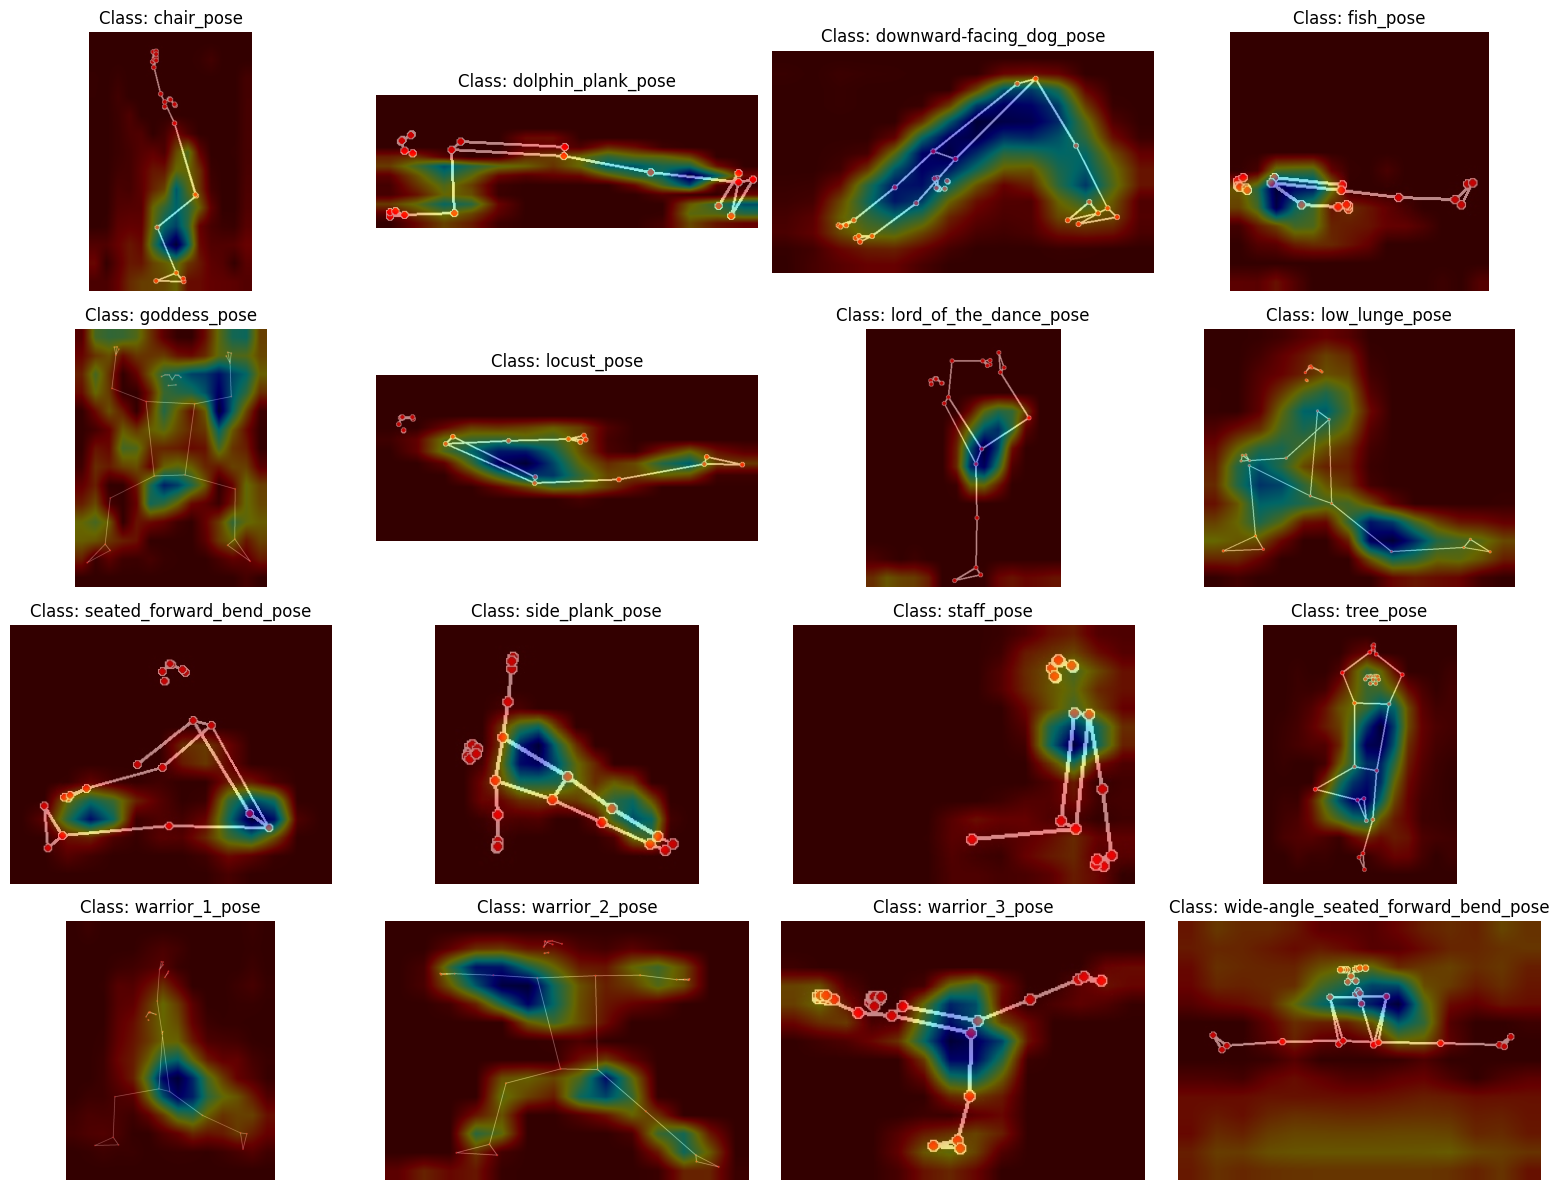

In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def get_gradcam_heatmap(model, img_array, layer_name, class_index):
    model.trainable = False
    grad_model = Model(inputs=model.input, outputs=[model.output, model.get_layer(layer_name).output])
    with tf.GradientTape() as tape:
        preds, conv_outputs = grad_model(np.array([img_array]))
        class_channel = preds[:, class_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    return superimposed_img

def plot_gradcam_from_folders(base_path, model, layer_name, target_size=(224, 224)):
    # Get list of folders
    class_folders = sorted(os.listdir(base_path))
    num_classes = min(len(class_folders), 16)  # Limit to 16 images for visualization

    plt.figure(figsize=(16, 12))
    for idx, folder in enumerate(class_folders):
        if idx >= num_classes:
            break
        folder_path = os.path.join(base_path, folder)
        img_name = os.listdir(folder_path)[0]  # Assumes one image per folder
        img_path = os.path.join(folder_path, img_name)

        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img, target_size) / 255.0

        # Generate Grad-CAM heatmap
        heatmap = get_gradcam_heatmap(model, resized_img, layer_name, idx)  # Assuming folder index corresponds to class index
        superimposed_img = display_gradcam(img, heatmap)

        # Plot Grad-CAM heatmap
        plt.subplot(4, 4, idx + 1)
        plt.imshow(superimposed_img)
        plt.title(f"Class: {folder}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `model` is your trained model
# Replace "last_conv_layer_name" with the actual name of the last convolutional layer in your model
base_test_path = "/kaggle/input/yoga-classification-research-data/mediapipe_skeleton_dataset/test"
plot_gradcam_from_folders(base_test_path, model, layer_name="block5_conv3")


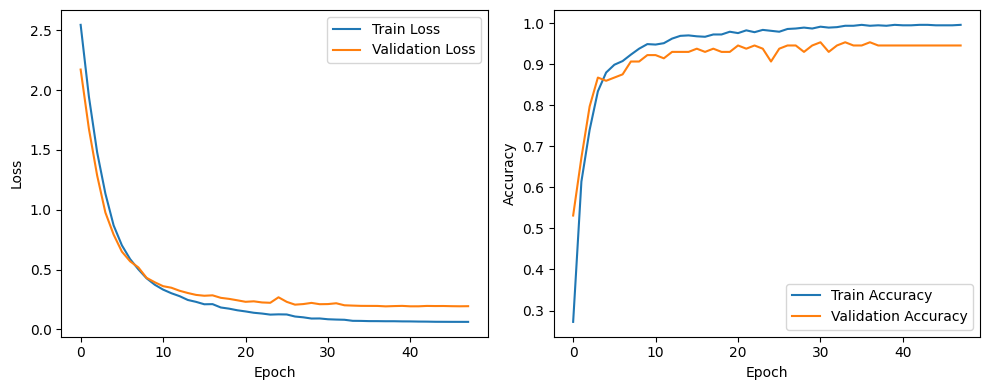

In [19]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
# After training the model
plot_training_history(history)

In [20]:
# Load the best model
model.load_weights('best_model.keras')

In [21]:
# Predict on the test set
test_generator.reset()
preds = model.predict(test_generator, steps=ceil(test_generator.samples / batch_size), verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes

4/4 [==============================] - 2s 563ms/step


In [22]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming true_labels and pred_labels are defined
class_names = [
    "Chair Pose",
    "Dolphin Plank Pose",
    "Downward Facing Dog Pose",
    "Fish Pose",
    "Goddess Pose",
    "Locust Pose",
    "Lord of the Dance Pose",
    "Low Lunge Pose",
    "Seated Forward Bend Pose",
    "Side Plank Pose",
    "Staff Pose",
    "Tree Pose",
    "Warrior 1 Pose",
    "Warrior 2 Pose",
    "Warrior 3 Pose",
    "Wide Angle Seated Forward Bend Pose"
]

# Print classification report
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# Convert metrics to percentages
acc = accuracy_score(true_labels, pred_labels)
overall_accuracy = acc * 100

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, pred_labels, average='weighted') * 100
overall_recall = recall_score(true_labels, pred_labels, average='weighted') * 100
overall_f1 = f1_score(true_labels, pred_labels, average='weighted') * 100

# Prepare data for DataFrame
data = {
    "Class": [],
    "Accuracy (%)": [],
    "Precision (%)": [],
    "Recall (%)": [],
    "F1-score (%)": []
}

# Populate data for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        per_class_accuracy = metrics['recall'] * 100  # Recall is equivalent to per-class accuracy
        data["Class"].append(class_name)
        data["Accuracy (%)"].append(f"{per_class_accuracy:.2f}")
        data["Precision (%)"].append(f"{metrics['precision'] * 100:.2f}")
        data["Recall (%)"].append(f"{metrics['recall'] * 100:.2f}")
        data["F1-score (%)"].append(f"{metrics['f1-score'] * 100:.2f}")

# Create a DataFrame
df_report = pd.DataFrame(data)

# Print overall accuracy and additional metrics
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall Precision: {overall_precision:.2f}%")
print(f"Overall Recall: {overall_recall:.2f}%")
print(f"Overall F1 Score: {overall_f1:.2f}%\n")

# Print the DataFrame
print(df_report.to_string(index=False))

Overall Accuracy: 96.48%
Overall Precision: 96.68%
Overall Recall: 96.48%
Overall F1 Score: 96.49%

                              Class Accuracy (%) Precision (%) Recall (%) F1-score (%)
                         Chair Pose        93.75         93.75      93.75        93.75
                 Dolphin Plank Pose        93.75        100.00      93.75        96.77
           Downward Facing Dog Pose       100.00        100.00     100.00       100.00
                          Fish Pose        87.50         93.33      87.50        90.32
                       Goddess Pose       100.00        100.00     100.00       100.00
                        Locust Pose       100.00         94.12     100.00        96.97
             Lord of the Dance Pose        93.75        100.00      93.75        96.77
                     Low Lunge Pose       100.00         94.12     100.00        96.97
           Seated Forward Bend Pose        87.50        100.00      87.50        93.33
                    Side Plank

[[15  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 15  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 14  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0 15]]


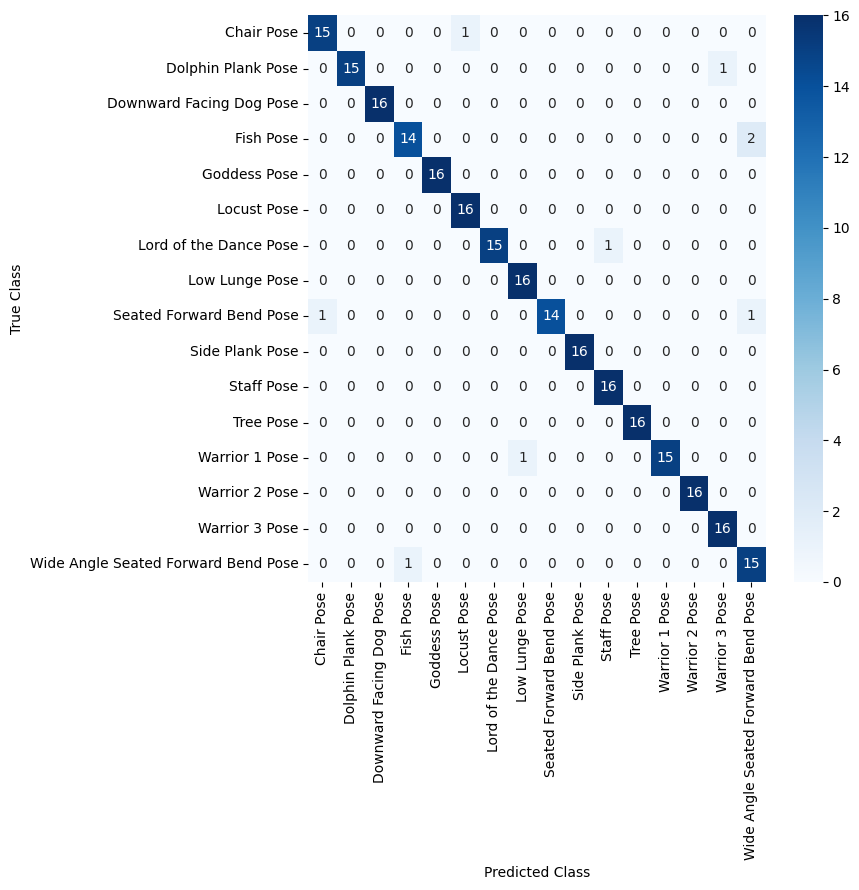

In [23]:
# Plot confusion matrix with class names
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(conf_matrix)
plt.figure(figsize=(9, 9))

# Use class_names for x-ticks and y-ticks
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=90)  # Rotate x-tick labels for better readability
plt.yticks(rotation=0)   # Keep y-tick labels horizontal
plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

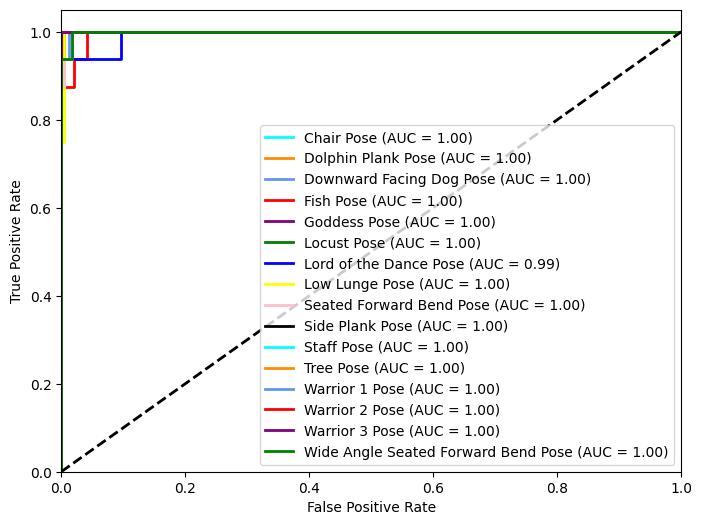

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# Number of classes
n_classes = len(class_names)

# Binarize the true labels for multi-class ROC computation
y_test_bin = label_binarize(true_labels, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'blue', 'yellow', 'pink', 'black'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{} (AUC = {:.2f})'.format(class_names[i], roc_auc[i]))

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Show the plot
plt.show()